# EELS SrFeO Project 
## RNN Autoencoder

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on RNN Autoencoder

* <span style="color: red"> // put resources here // </span>

### Import Package

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  
 
# Do other imports now...
import keras

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [87]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [88]:
# checking device (GPU & CPU)
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6924124847573541738
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6692472303890642498
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10753907098
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15261877524318756630
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:05:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2549817981279939634
physical_device_desc: "device: XLA_GPU device"
]


## Load Data

In [97]:
#data = hs.load("processed_data/EELS_raw_*.hdf5")
import pickle
class Container(object): pass
temporal_data = list()
for k in range(49):
    f = pickle.load(open("processed_data/EELS_o_range_"+str(k)+".pkl", 'rb'))
    temporal_data.append(f)

In [98]:
temporal_data[0].O_range.shape

(26, 114, 32)

### Cropping spectral image

(17, 114)


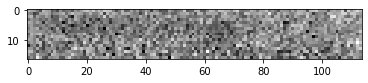

In [99]:
# Visualizing cropped area
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

cropped = np.average(temporal_data[3].data[8:25], axis=(2))
print(cropped.shape)

fig, ax = plt.subplots()
im = ax.imshow(cropped)

In [100]:
# window is y = [7:35]
def crop(data):
    for k,sp in enumerate(data):
        data[k].data = sp.data[8:25]
        print(str(k)+"/len(data)"+": "+str(data[k].data.shape), end="\r")

In [101]:
crop(temporal_data)

## Applying RNN Autoencoder to temporal data

### Downsampling

Done to reduce data size.

#### Resources
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean

In [105]:
from scipy.signal import resample
import itertools

def downsample(stacked_data, N_resampled:int):
    """
    down sampling the data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    N_resampled: int
        number of samples in the resampled set
    """
    dim = stacked_data[0].data.shape
    if N_resampled != dim[2]: 
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], N_resampled))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = resample(stacked_data[k].data[i][j][:], N_resampled) 
    else:
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], dim[2]))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = stacked_data[k].data[i][j][:]
    #for k in range(len(stacked_data)):
        #stacked_data[k].O_range = stacked_data[k].resample

In [106]:
np.array(temporal_data).shape

(49,)

In [107]:
N_resampled = 1000
#N_resampled = temporal_data[0].data.shape[2]
downsample(temporal_data, N_resampled)

### Section out region of interest (ROI)

In [196]:
def cut_ROI(data, N_resampled):
    '''
    Cutting region of interest to be analyzed
    
    Parameters
    -----------
    data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    
    N_resampled: int
        number of samples in the resampled set
    '''
    import math
    N_0 = data[0].data.shape[2]
    
    o_range = (680,980)
    fe_range = (2070,2350)
    anly_o_range = o_range[1] - o_range[0]
    anly_fe_range = fe_range[1] - fe_range[0]
    
    oc0 = math.ceil(o_range[0]/N_0*N_resampled)
    oc1 = math.ceil(o_range[1]/N_0*N_resampled)
    fc0 = math.ceil(fe_range[0]/N_0*N_resampled)
    fc1 = math.ceil(fe_range[1]/N_0*N_resampled)

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.resample.shape[0], spectra.resample.shape[1], oc1-oc0))
        data[k].Fe_range = np.zeros((spectra.resample.shape[0], spectra.resample.shape[1], fc1-fc0))
        #print(math.ceil((o_range[1]+anly_o_range)/N_0*N_resampled))
        for i in range(spectra.resample.shape[0]):
            for j in range(spectra.resample.shape[1]):
                data[k].O_range[i][j] = spectra.resample[i][j][oc0:oc1]
                data[k].Fe_range[i][j] = spectra.resample[i][j][fc0:fc1]

In [197]:
cut_ROI(temporal_data, N_resampled)

(17, 114, 76)


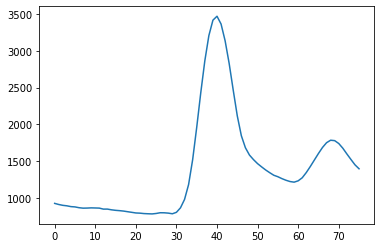

In [198]:
plt.plot(np.sum(temporal_data[6].Fe_range[:1], axis=(0,1)))
print(temporal_data[6].Fe_range.shape)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

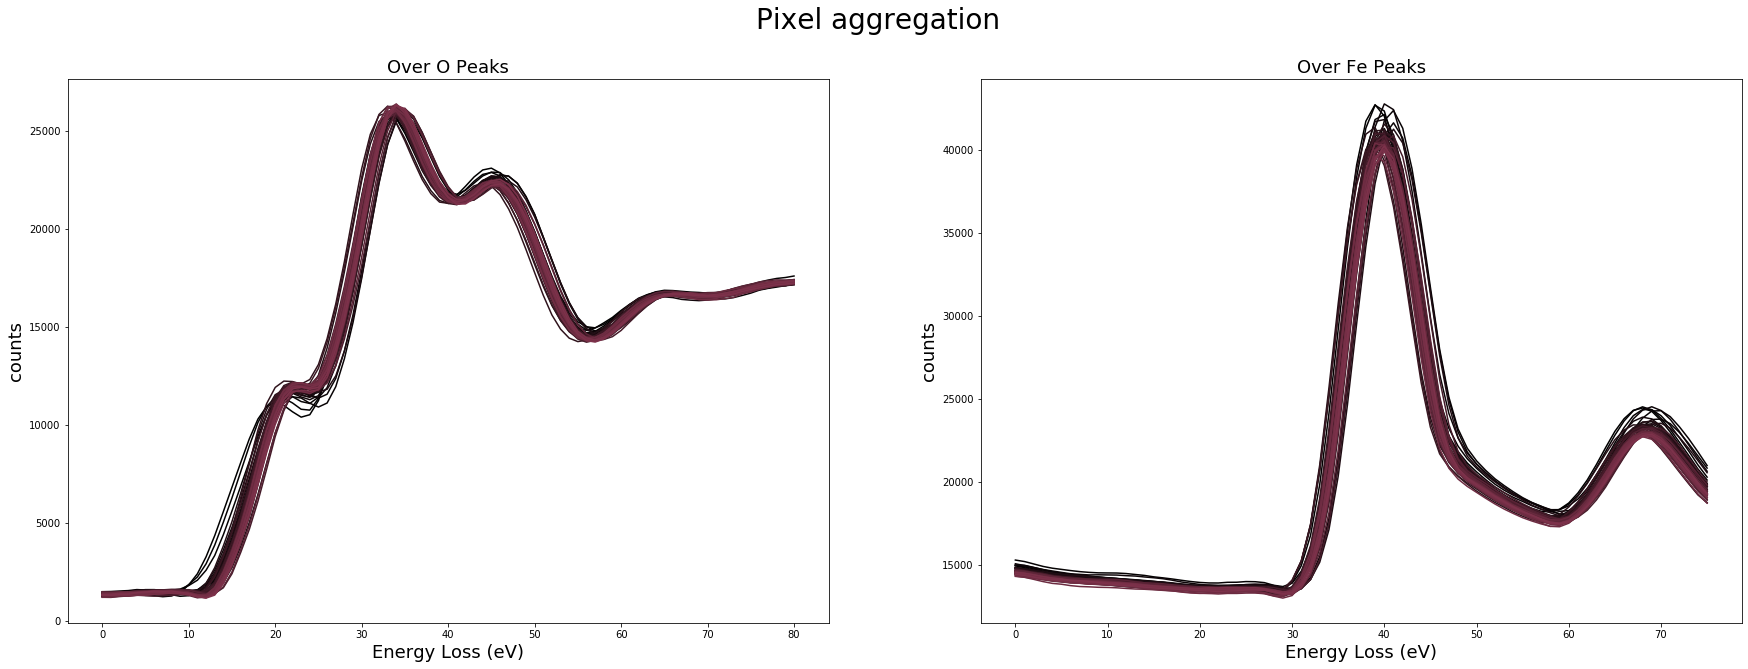

In [199]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3,ax4) = plt.subplots(1,2, figsize=(30,10))
for k in range(len(temporal_data)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(temporal_data[k].O_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))
    # Plotting aggregation over Fe range
    ax4.plot(np.sum(temporal_data[k].Fe_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))

# plot configurations
g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)  

In [202]:
# rearrange dimension
arrayx = list()
dim = temporal_data[0].Fe_range.shape
for i in range(len(temporal_data)):
    f = temporal_data[i].Fe_range.reshape((-1,dim[2]))
    arrayx.append(f)
arrayx = np.array(arrayx).reshape((-1,dim[2]))

In [203]:
arrayx.shape

(94962, 76)

### Setting up RNN autoencoder

In [204]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Conv2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [227]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.02,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(N_steps, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [228]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_train), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_test), np.atleast_3d(data_test)))

In [229]:
# construct a model
model3 = rnn_autoencoder(LSTM, 76, 3, 3, 9, 76)

In [230]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 76, 76)            23712     
_________________________________________________________________
lstm_36 (LSTM)               (None, 76, 76)            46512     
_________________________________________________________________
lstm_37 (LSTM)               (None, 76)                46512     
_________________________________________________________________
encoding (Dense)             (None, 9)                 693       
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 76, 9)             0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 76, 76)            26144     
_________________________________________________________________
lstm_39 (LSTM)               (None, 76, 76)           

### Training RNN Autoencoder

In [287]:
# set learning rate and compile model
lr = 2e-6
model3.compile(Adam(lr), loss='mse')
folder_name = 'rnn_auto_deep2_checkpoints'

In [289]:
a = np.concatenate([arrayx[:r[0]],arrayx[r[1]:]])
np.random.shuffle(a)

In [290]:
r = (int(arrayx.shape[0]/(temporal_data[0].O_range.shape[0]*temporal_data[0].O_range.shape[1])*(int(len(temporal_data)/2)-2)),
     int(arrayx.shape[0]/(temporal_data[0].O_range.shape[0]*temporal_data[0].O_range.shape[1])*(int(len(temporal_data)/2)+2)))

In [ ]:
train_model(model3, a, arrayx[r[0]:r[1]], folder_name, epochs=100, batch_size=200)

Train on 94766 samples, validate on 196 samples
Epoch 1/100
94766/94766 [==============================] - 129s 1ms/step - loss: 1.2517 - val_loss: 0.9450
Epoch 2/100
94766/94766 [==============================] - 123s 1ms/step - loss: 1.2462 - val_loss: 0.9433
Epoch 3/100
94766/94766 [==============================] - 124s 1ms/step - loss: 1.2443 - val_loss: 0.9401
Epoch 4/100
94766/94766 [==============================] - 123s 1ms/step - loss: 1.2448 - val_loss: 0.9378
Epoch 5/100
94766/94766 [==============================] - 122s 1ms/step - loss: 1.2303 - val_loss: 0.9373
Epoch 6/100
94766/94766 [==============================] - 123s 1ms/step - loss: 1.2544 - val_loss: 0.9359
Epoch 7/100
94766/94766 [==============================] - 124s 1ms/step - loss: 1.2507 - val_loss: 0.9306
Epoch 8/100
94766/94766 [==============================] - 123s 1ms/step - loss: 1.2560 - val_loss: 0.9364
Epoch 9/100
94766/94766 [==============================] - 124s 1ms/step - loss: 1.2568 - val_lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



94766/94766 [==============================] - 124s 1ms/step - loss: 1.2300 - val_loss: 0.9274
Epoch 19/100
94766/94766 [==============================] - 124s 1ms/step - loss: 1.2211 - val_loss: 0.9257
Epoch 20/100
94766/94766 [==============================] - 129s 1ms/step - loss: 1.2224 - val_loss: 0.9217
Epoch 21/100
94766/94766 [==============================] - 127s 1ms/step - loss: 1.2321 - val_loss: 0.9265
Epoch 22/100
94766/94766 [==============================] - 124s 1ms/step - loss: 1.2313 - val_loss: 0.9251
Epoch 23/100
94766/94766 [==============================] - 126s 1ms/step - loss: 1.2389 - val_loss: 0.9230
Epoch 24/100
94766/94766 [==============================] - 135s 1ms/step - loss: 1.2417 - val_loss: 0.9204
Epoch 25/100
94766/94766 [==============================] - 136s 1ms/step - loss: 1.2212 - val_loss: 0.9211
Epoch 26/100
94766/94766 [==============================] - 130s 1ms/step - loss: 1.2307 - val_loss: 0.9211
Epoch 27/100
94766/94766 [===============

Epoch 94/100
94766/94766 [==============================] - 125s 1ms/step - loss: 1.2028 - val_loss: 0.9050
Epoch 95/100
94766/94766 [==============================] - 125s 1ms/step - loss: 1.1864 - val_loss: 0.9021
Epoch 96/100
66800/94766 [====================>.........] - ETA: 36s - loss: 1.2089

### <span style="color:blue"> Training may take a few days depending on epochs. </span>
    At this point, just let the training run in the background. 
    Go to the next notebook to analyze the trained results.

## Load model

In [25]:
# load weights
model3.load_weights(folder_name+"/weights.21-0.13645907.hdf5")

# Compile model (required to make predictions)
lr = 5e-3
model3.compile(Adam(lr), loss='mse')

## Make Prediction

In [26]:
test = arrayx[48000-1:72000-1]
test.shape

(24000, 81)

In [27]:
predict = model3.predict(np.atleast_3d(test))

W1216 15:37:31.930732 140544216844096 deprecation_wrapper.py:119] From /home/pht219/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [28]:
predict.shape

(24000, 81, 1)

Text(0.5, 0.98, 'Spectra Prediction - RNN Autoencoder (LSTM, 81, 5, 5, 9, 81)\n Labeled EELS data (anneal)')

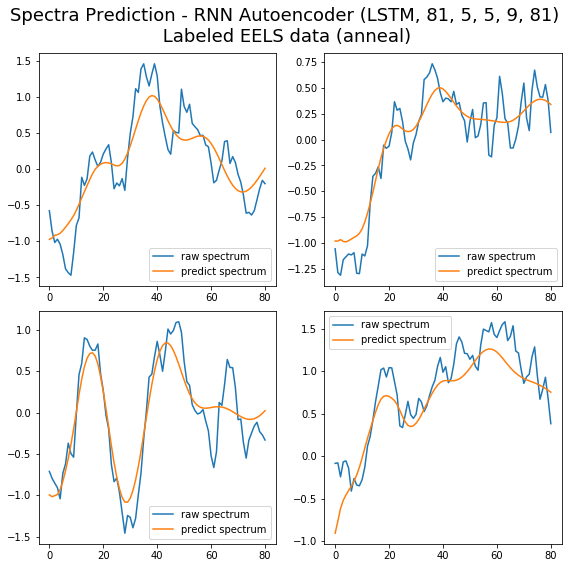

In [29]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
from sklearn import preprocessing
#y1_norm = preprocessing.normalize(x_test)
#y2_norm = preprocessing.normalize(y_predict.reshape(-1,128))
y1_norm = test
y2_norm = predict.reshape(-1,81)
axs.reshape(-1)
for i in range (0,2):
    for j in range(0,2):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
        ax.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Spectra Prediction - RNN Autoencoder (LSTM, 81, 5, 5, 9, 81)"\
             "\n Labeled EELS data (anneal)", fontsize =18)

In [30]:
def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
        
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = backend.function([model.layers[0].input, 
                                            backend.learning_phase()], 
                                           [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output

In [31]:
activation = get_ith_layer_output(model3, np.atleast_3d(test), 5)

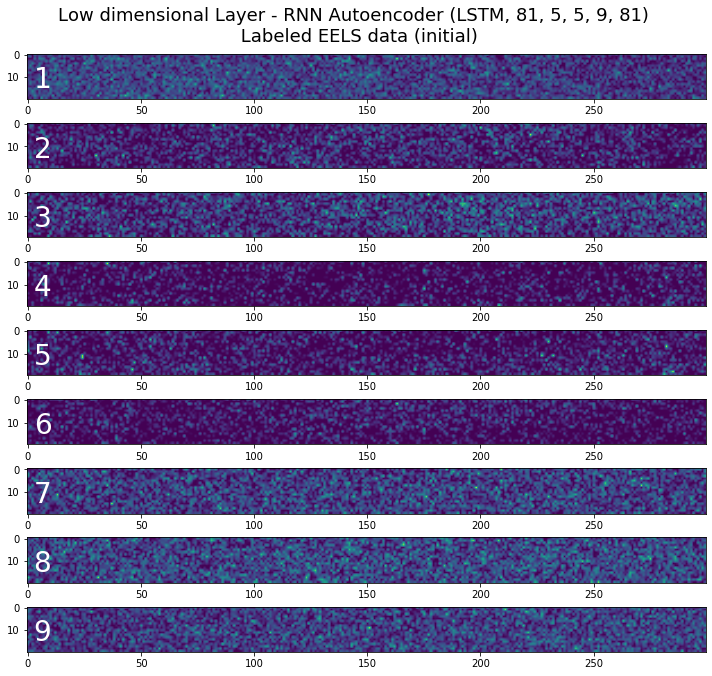

In [32]:
actv = activation.reshape(4,20,300,9)
fig, axs = plt.subplots(9, 1, figsize=(10, 10))
for k in range(9):
    ax = axs[k]
    ax.imshow(actv[0,:,:,k], cmap='viridis', interpolation='bilinear')
    #ax.pcolor(actv[0,:,:,k], cmap='viridis')
    ax.set_title(str(k+1), fontsize=28, color='white', loc='left', y=0.1, x=0.01)
fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 5, 5, 9, 81)"\
             " \n Labeled EELS data (initial)", fontsize=18)
plt.subplots_adjust(top=2.25)
plt.tight_layout()

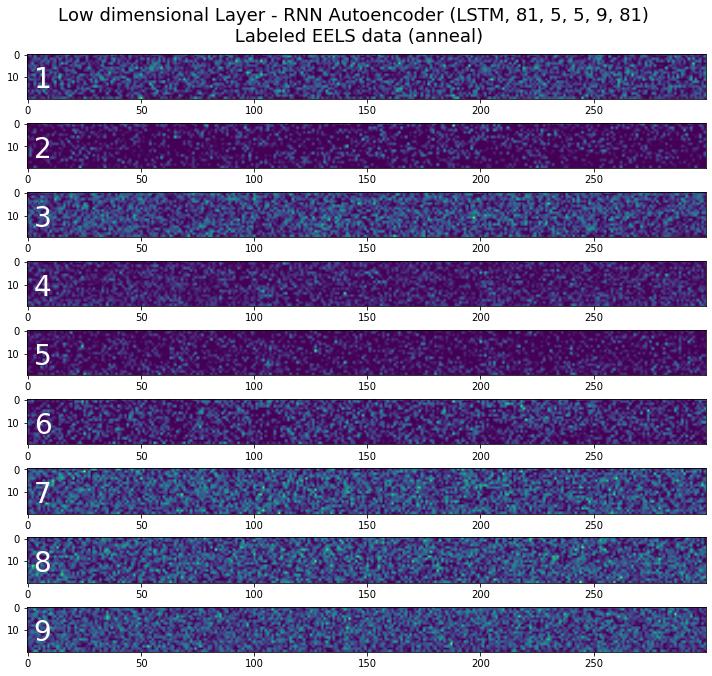

In [33]:
actv = activation.reshape(4,20,300,9)
fig, axs = plt.subplots(9, 1, figsize=(10, 10))
for k in range(9):
    ax = axs[k]
    ax.imshow(actv[3,:,:,k], cmap='viridis', interpolation='bilinear')
    #ax.pcolor(actv[0,:,:,k], cmap='viridis')
    ax.set_title(str(k+1), fontsize=28, color='white', loc='left', y=0.1, x=0.01)
fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 5, 5, 9, 81)"\
             " \n Labeled EELS data (anneal)", fontsize=18)
plt.subplots_adjust(top=2.25)
plt.tight_layout()

## Setup and run NMF 

In [48]:
import sklearn
numNMFcomp = 8
NMFcomponents = list()
NMFembeddings = list()
for k in range(len(actv)):
    arrayx = np.array(actv[k])
    dim = arrayx.shape
    arrayx = arrayx.reshape((-1,dim[2]))
   
    # setup NMF 
    NMFmodel = sklearn.decomposition.NMF(n_components=numNMFcomp, 
                                     init='random',
                                     random_state=0, 
                                     alpha=1e-7, 
                                     l1_ratio=1)

    # computes NMF
    data_for_nmf = arrayx.reshape((-1,dim[2]))
    comp = NMFmodel.fit_transform(np.rollaxis(data_for_nmf - np.min(data_for_nmf), 1))
    comp = np.swapaxes(comp,0,1)

    emb = np.rollaxis(NMFmodel.components_, 1)
    emb = emb.reshape((dim[0],dim[1],numNMFcomp))
     
    NMFembeddings.append(emb)
    NMFcomponents.append(comp)

In [49]:
NMFembeddings = np.array(NMFembeddings)
NMFembeddings.shape

(4, 20, 300, 8)

## Plot NMF map

fig size: 72.0 DPI, size in inches [ 6. 12.]


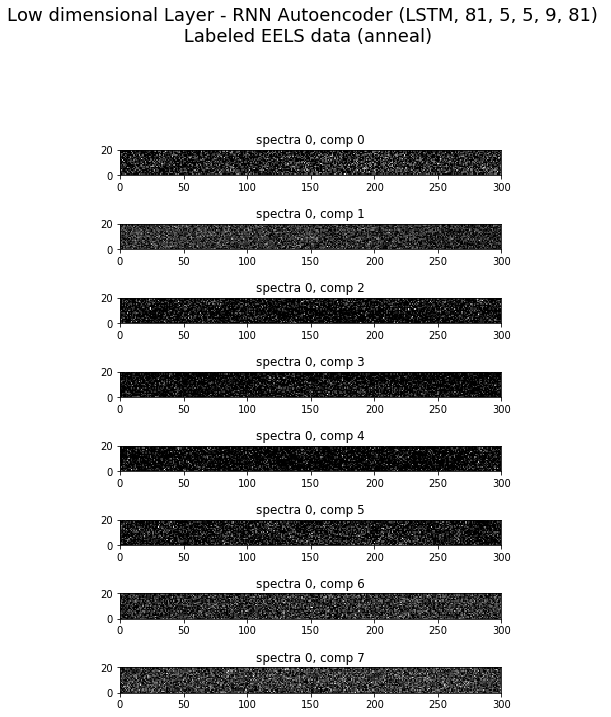

In [54]:
import sys
from matplotlib.animation import FuncAnimation
ax=[]
fig, (ax) = plt.subplots(numNMFcomp, 1, figsize=(6,12))
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(k):
    label = 'timestep {0}'.format(k)
    for i in range(numNMFcomp):
        pcolor = ax[i].pcolor(NMFembeddings[k][:,:,i])
        ax[i].axis('scaled')
        #ax[i].invert_yaxis()
        #pcolor.set_clim(0, 2)
        #fig.colorbar(pcolor)
        ax[i].set_title("spectra "+str(k)+", comp "+str(i))
    fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 5, 5, 9, 81)"\
                 " \n Labeled EELS data (anneal)", fontsize=18)
    plt.tight_layout()
    #plt.subplots_adjust(top=2.25)
    print(label, end='\r')
    return ax

#if __name__ == '__main__':
# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, len(NMFembeddings)), interval=300)
#if len(sys.argv) > 1 and sys.argv[1] == 'save':
anim.save('NMF_RNNAuto.gif', dpi=80, writer='imagemagick')
#else:
    # plt.show() will just loop the animation forever.
#    plt.show()

## PCA

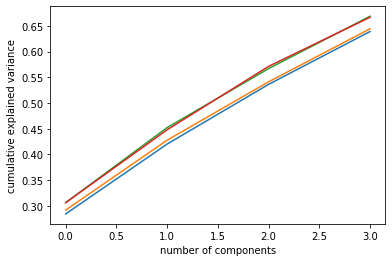

In [69]:
numPCAcomp=4
PCAembeddings = list()
PCAcomponents = list()
for k in range(len(actv)):
    arrayx = np.array(actv[k])
    sha = arrayx.shape
    pca = sklearn.decomposition.PCA(n_components=numPCAcomp)
    PCA = pca.fit(arrayx.reshape((-1,sha[2])))
    container = PCA.transform(arrayx.reshape((-1,sha[2])))[:, 0:numPCAcomp].reshape((sha[0],sha[1],-1))
    PCAcomponents.append(container)
    PCAembeddings.append(PCA)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

In [64]:
PCAcomponents[0].shape

(20, 300, 8)

In [65]:
plt.plot(np.cumsum(PCAcomponents[0].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'